# Find and Remove Confounders in Pan-Cancer Data-set

Here we are going through a number of clinical variables and finding confounders which may effect a genomic analysis of the data. We opted not to just use everything multivariate modeling of covariates as it would create a very complicated model considering we already have ~15 degrees of freedom with our tissue type variable. The strategy here is to isolate factors which have a large influence on outcome and to filter those out to try and get at a more homogenous set of patients. 

In [1]:
import NotebookImport
from ClinicalData import *

importing IPython notebook from ClinicalData

PCPG
UCS
TGCT
CHOL
THYM
MESO
FPPP


/cellar/users/agross/anaconda2/lib/python2.7/site-packages/Processing/ProcessClinicalDataPortal.py:37: SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index,col_indexer] = value instead
  f['vitalstatus'] = f['daystodeath'].isnull()


In [24]:
from Figures.Survival import survival_and_stats
from Stats.Survival import get_cox_ph_ms, get_cox_ph, get_surv_fit
from Figures.FigureHelpers import *

In [3]:
%matplotlib inline

## Tissue Type  
* We want to use as much data as possible, but some tissues are outliers in their patient prognosis

### Five year survival curves for all tissue types

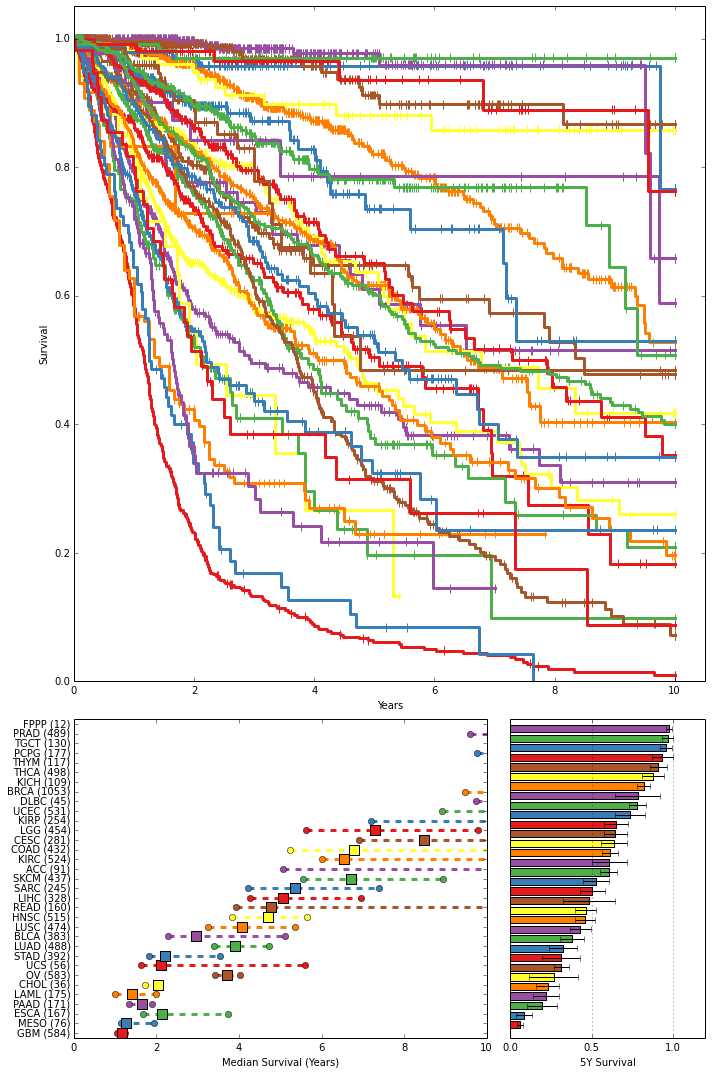

In [9]:
#Do not import
c2 = codes[codes.isin(ti(codes.value_counts() > 30))]
survival_and_stats(c2, surv_10y, upper_lim=10, figsize=(10,15))

### Characteristics of all tissue types 
* Here we can see that a disproportionate number of the of the deaths is in the GBM cohort 
* Conversely we have very few deaths for the KICH, THCA, and PRAD datasets 

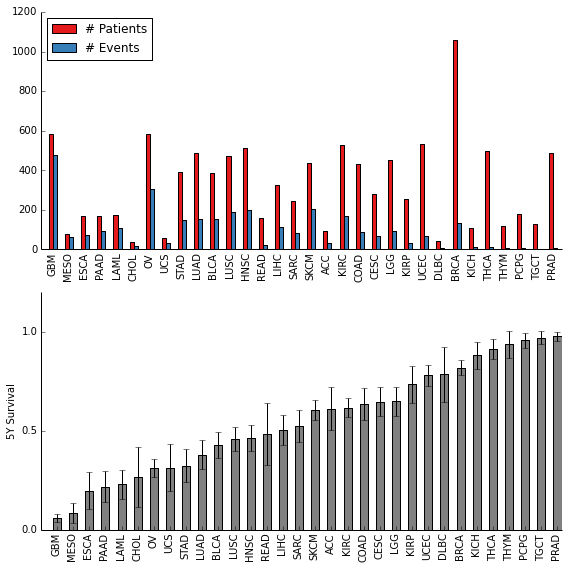

In [19]:
#Do not import
fig, axs = plt.subplots(2,1, figsize=(8,8))
ax = axs[0]

t = get_surv_fit(surv, codes)
t = t.sort([('5y Survival','Surv')])
t['Stats'].plot(kind='bar', ax=ax)
prettify_ax(ax)

ax2 = axs[1]
t = get_surv_fit(surv, codes)
tt = t['5y Survival'].sort('Surv')
b = (tt['Surv']).plot(kind='bar', ax=ax2, color='grey',
     yerr=[tt.Surv-tt.Lower, tt.Upper-tt.Surv], ecolor='black')
ax2.set_ylabel('5Y Survival')
ax2.set_yticks([0, .5, 1.])
prettify_ax(ax2)
fig.tight_layout()

In [20]:
fys = get_surv_fit(surv, codes)['5y Survival']['Surv'].order()
nn  = codes.isin(true_index((fys > .1) & (fys < .83)))
fys

GBM     0.060596
MESO    0.084220
ESCA    0.197024
PAAD    0.217449
LAML    0.229317
CHOL    0.266965
OV      0.312040
UCS     0.314376
STAD    0.323436
LUAD    0.379299
BLCA    0.429483
LUSC    0.459448
HNSC    0.463453
READ    0.484140
LIHC    0.504273
SARC    0.526236
SKCM    0.604438
ACC     0.610429
KIRC    0.617604
COAD    0.636490
CESC    0.647546
LGG     0.650240
KIRP    0.734933
UCEC    0.781401
DLBC    0.785608
BRCA    0.819809
KICH    0.880753
THCA    0.912207
THYM    0.936165
PCPG    0.957624
TGCT    0.970106
PRAD    0.976886
Name: Surv, dtype: float64

## Age 

In [21]:
age = pd.concat([c.clinical.daystobirth for c in clinical.values()])
age = -1*np.floor(age.astype(float) / 365.25)
a2 = a2 = pd.concat([c.clinical.age for c in clinical.values()])
age = age.combine_first(a2)
age = age.groupby(level=0).min()
age = age.fillna(age.median())
age.name = 'age'

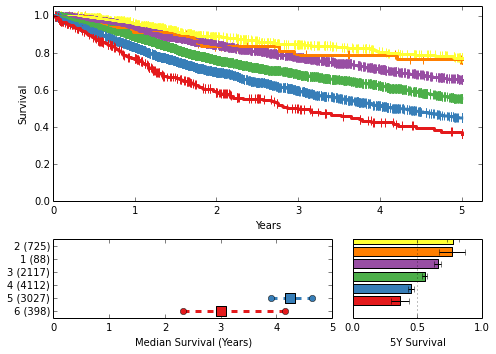

In [22]:
#Do not import
survival_and_stats((age / 15).round(), surv_5y)


         coef exp(coef) se(coef)   z p
feature 0.863      2.37   0.0969 8.9 0

Likelihood ratio test=61.7  on 1 df, p=4e-15  n= 10467, number of events= 2845 



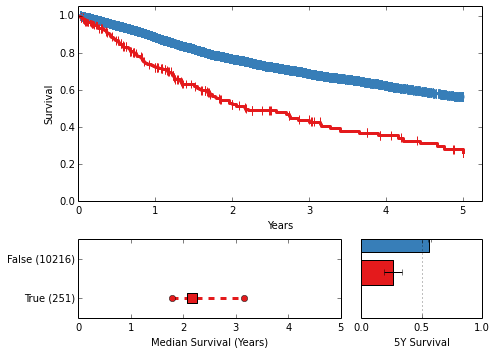

In [25]:
#Do not import
survival_and_stats(age.dropna() >= 85, surv_5y)
get_cox_ph(surv_5y, age >= 85, print_desc=True);

In [26]:
old = age >= 75
old.name = 'age_over_75'

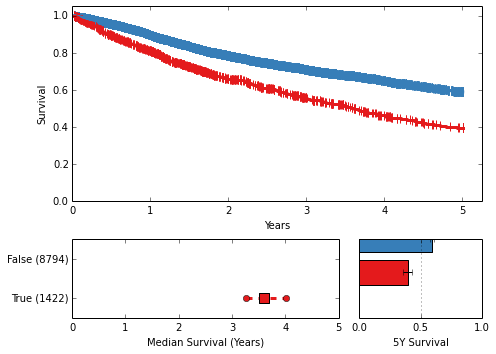

In [27]:
#Do not import
survival_and_stats(old.ix[ti(age < 85)], surv_5y)

## Year of Diagnosis

In [28]:
year = pd.concat([c.clinical.yearofinitialpathologicdiagnosis for c in clinical.values()])
year = year.groupby(level=0).first().replace('[Discrepancy]', np.nan).astype(float).dropna()

LR                                          2.860767e-11
feature_p                                            NaN
fmla         Surv(days, event) ~ codes + codes:feature\n
hazzard                                              NaN
dtype: object

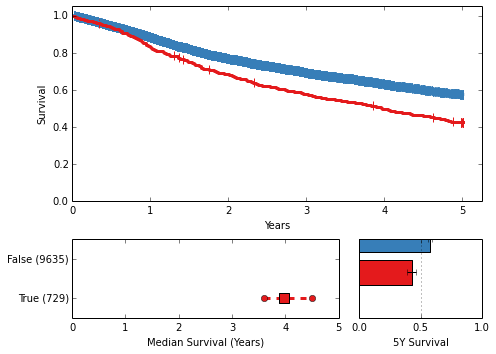

In [29]:
#Do not import
survival_and_stats(year <= 2000, surv_5y)
get_cox_ph_ms(surv_5y, year < 2000, [codes])

## Residual Tumor 
* This will likely effect survival but should (for the most part) be independent of the genetics of the tumor

In [30]:
r_status = pd.concat([c.clinical.residualtumor for c in clinical.values() if 'residualtumor' 
                      in c.clinical])
r_status = r_status.replace(['[Not Evaluated]', '[Unknown]', 'RX','rx'])
r_status = r_status.str.lower()
r_status = r_status.groupby(level=0).first()


        coef exp(coef) se(coef)    z p
feature 1.22       3.4    0.108 11.3 0

Likelihood ratio test=91.9  on 1 df, p=0  n= 5229, number of events= 1386 



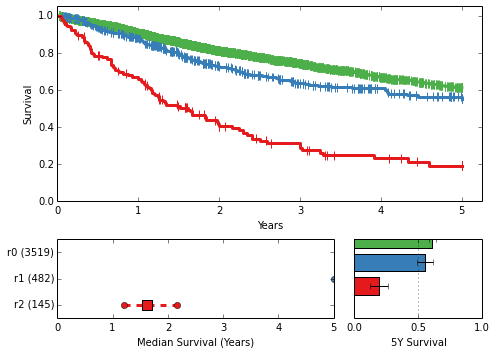

In [31]:
#Do not import
survival_and_stats(r_status.dropna(), surv_5y)
get_cox_ph(surv_5y, r_status=='r2', print_desc=True);

## Margin Status 
* Interestingly has little effect on survival

In [32]:
margin_status = pd.concat([c.clinical.marginstatus for c in clinical.values() 
                           if 'marginstatus' in c.clinical])
margin_status = margin_status.groupby(level=0).first()

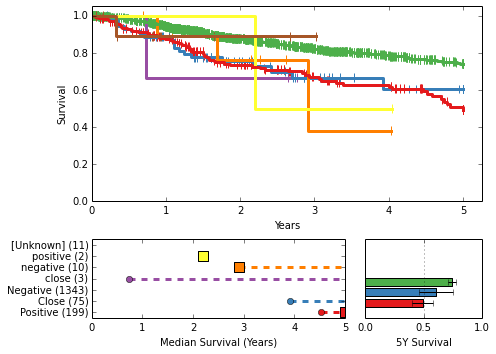

In [33]:
#Do not import
survival_and_stats(margin_status.dropna(), surv_5y)

## Stage
* We try pathologic stage first and then clinical stage 
* I'm just using the broad stage number rather than subcategories 
* Many patients are missing stage information

In [34]:
s = {}
for can,c in clinical.iteritems():
    if 'pathologicstage' in c.stage:
        s[can] = c.stage.pathologicstage
    elif 'clinicalstage' in c.stage:
        s[can] = c.stage.clinicalstage
stage = pd.concat(s.values())
stage = stage.groupby(level=0).first()
stage = stage.str.lower()
#stage = stage.ix[surv.unstack().index].fillna('missing')
stage = stage.replace(['[unknown]','[discrepancy]','stage x','stage tis','i or ii nos', 'stage 0'], np.nan).dropna()
stage = stage.dropna().map(lambda s: s.split(' ')[1])
stage = stage.dropna().map(lambda s: s.replace('a','').replace('b','').replace('c',''))
stage = stage.dropna().map(lambda s: s.replace('1','').replace('2',''))
stage = 'Stage ' + stage.str.upper()
stage.name = 'stage'
stage = stage[stage.isin(ti(stage.value_counts()>10))]
gbm = pd.Series('Stage IV', ti(codes == 'GBM'))
lgg = pd.Series('Stage I', ti(codes == 'LGG'))
stage = lgg.combine_first(gbm.combine_first(stage))
stage = stage.ix[codes.index].fillna('Missing')
stage = stage.map(str.lower).map(lambda s: s.replace(' ', '_'))
stage.name = 'stage'


        coef exp(coef) se(coef)    z p
feature  1.4      4.06   0.0401 34.9 0

Likelihood ratio test=999  on 1 df, p=0  n= 10467, number of events= 2845 



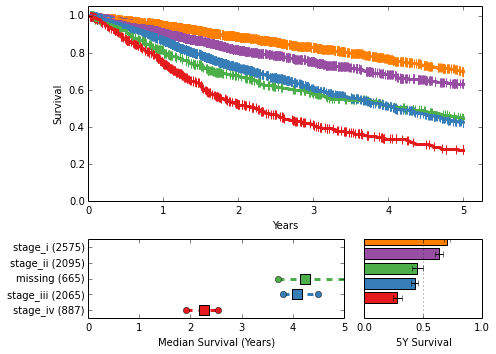

In [35]:
#Do not import
survival_and_stats(stage.ix[true_index(nn)].dropna(), surv_5y)
get_cox_ph(surv_5y, stage == 'stage_iv', print_desc=True);

## M-Stage  
* Overlaps with stage but slightly different 
* In HNSCC stage IVa is M0

In [36]:
mets = pd.concat([c.stage.pathologicm for can,c in clinical.iteritems() 
                  if 'pathologicm' in c.stage])
mets = mets.groupby(level=0).first()
mets = pd.concat([c.stage.pathologicm for can,c in clinical.iteritems() 
                  if 'pathologicm' in c.stage])
mets = mets.groupby(level=0).first()
mets = mets.dropna().map(lambda s: s.replace('a','').replace('b','').replace('c',''))
mets = mets.replace(['[Unknown]','MX'], np.nan).dropna()
mets = mets=='M1'
mets.name = 'metastasis'


        coef exp(coef) se(coef)    z p
feature 1.18      3.27   0.0812 14.6 0

Likelihood ratio test=161  on 1 df, p=0  n= 5076, number of events= 1251 



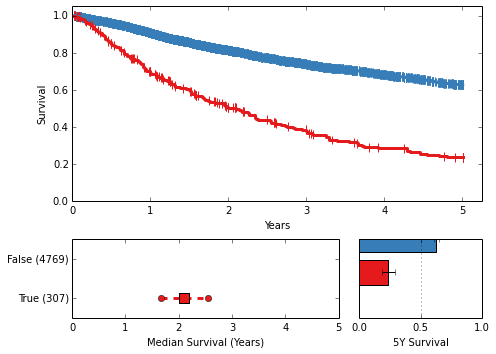

In [37]:
#Do not import
survival_and_stats(mets, surv_5y)
get_cox_ph(surv_5y, mets, print_desc=True);

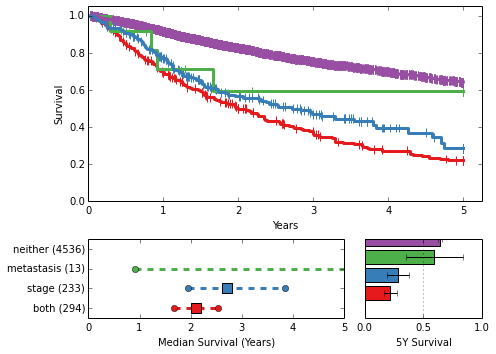

In [38]:
#Do not import
survival_and_stats(combine(mets, stage=='stage_iv'), surv_5y)

# Form final Pan-Cancer working set of patients

In [39]:
filters = pd.concat([age > 85, mets, r_status=='r2', stage=='stage iv', nn==False], 1)
keepers = true_index((filters > 0).sum(1) == 0)
keepers = keepers.intersection(surv_5y.unstack().index)
keepers = keepers.intersection(codes.index)

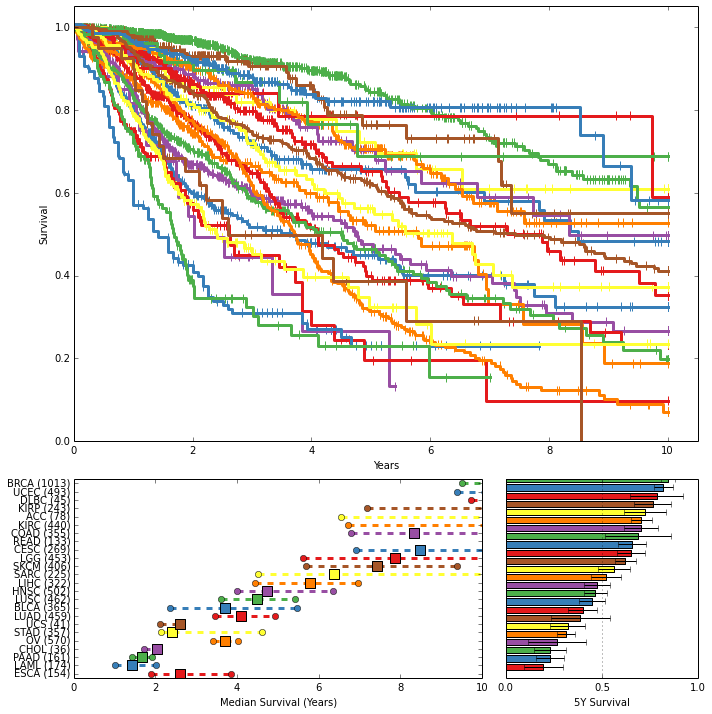

In [40]:
#Do not import
survival_and_stats(codes.ix[keepers].order(), surv_10y, upper_lim=10, figsize=(10,10))